In [ ]:
import csv
import os

# Input and output file paths
input_file = "/home/hp/Study/Code/AI/Detecting-reversal-point-in-equity-US/detecting-reversal-points-in-us-equities/competition_data/train.csv"
output_file = "modified_train.csv"

# Function to process the CSV
def process_csv(input_path, output_path):
    with open(input_path, 'r', newline='') as infile, open(output_path, 'w', newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        
        # Read the header row
        header = next(reader)
        
        # Identify indices of columns with specific prefixes
        happens_within_indices = [i for i, col in enumerate(header) if col.startswith('happens_within')]
        occurs_within_indices = [i for i, col in enumerate(header) if col.startswith('occurs_within')]
        crossing_above_indices = [i for i, col in enumerate(header) if col.startswith('cross_threshold_from_above')]
        crossing_below_indices = [i for i, col in enumerate(header) if col.startswith('cross_threshold_from_below')]
        trending_down_indices = [i for i, col in enumerate(header) if col.startswith('trending_down_and_above')]
        trending_up_indices = [i for i, col in enumerate(header) if col.startswith('trending_up_and_below')]
        troughs_indices = [i for i, col in enumerate(header) if col.startswith('troughs')]
        zone_indices = [i for i, col in enumerate(header) if col.startswith('zone')]
        peaks_indices = [i for i, col in enumerate(header) if col.startswith('peaks')]
        
        # Keep columns that are not any of the specified prefixes
        other_indices = [i for i, col in enumerate(header) if not (
            col.startswith('happens_within') or 
            col.startswith('occurs_within') or 
            col.startswith('cross_threshold_from_above') or 
            col.startswith('cross_threshold_from_below') or
            col.startswith('trending_down_and_above') or
            col.startswith('trending_up_and_below') or
            col.startswith('troughs') or
            col.startswith('zone') or
            col.startswith('peaks')
        )]
        
        # Create new header: keep other columns, add new columns for counts
        new_header = [header[i] for i in other_indices] + [
            'happens_within', 
            'occurs_within', 
            'cross_threshold_from_above', 
            'cross_threshold_from_below',
            'trending_down_and_above',
            'trending_up_and_below',
            'troughs',
            'zone',
            'peaks'
        ]
        writer.writerow(new_header)
        
        # Process each data row
        for row in reader:
            # Count "True" values in each set of columns
            happens_within_count = sum(1 for i in happens_within_indices if row[i] == 'True')
            occurs_within_count = sum(1 for i in occurs_within_indices if row[i] == 'True')
            crossing_above_count = sum(1 for i in crossing_above_indices if row[i] == 'True')
            crossing_below_count = sum(1 for i in crossing_below_indices if row[i] == 'True')
            trending_down_count = sum(1 for i in trending_down_indices if row[i] == 'True')
            trending_up_count = sum(1 for i in trending_up_indices if row[i] == 'True')
            troughs_count = sum(1 for i in troughs_indices if row[i] == 'True')
            zone_count = sum(1 for i in zone_indices if row[i] == 'True')
            peaks_count = sum(1 for i in peaks_indices if row[i] == 'True')
            
            # Create new row: keep other columns, add counted columns
            new_row = [row[i] for i in other_indices] + [
                str(happens_within_count), 
                str(occurs_within_count), 
                str(crossing_above_count), 
                str(crossing_below_count),
                str(trending_down_count),
                str(trending_up_count),
                str(troughs_count),
                str(zone_count),
                str(peaks_count)
            ]
            writer.writerow(new_row)

# Execute the processing
process_csv(input_file, output_file)
print(f"Processed CSV saved as {output_file}")

In [76]:
import pandas as pd
import numpy as np

# File path for train
input_file = "modified_train.csv"

# Load the CSV into a Pandas DataFrame
df = pd.read_csv(input_file)

# Simplify class labels
df['class_label'] = df['class_label'].fillna('N')
df["class_label"] = df["class_label"].replace({"HH": "H", "LH": "H", "LL": "L", "HL": "L", '': 'N'})

# Split into separate DataFrames based on ticker_id
df_001 = df[df['ticker_id'] == 1].copy()
df_002 = df[df['ticker_id'] == 2].copy()
df_003 = df[df['ticker_id'] == 3].copy() 
df_004 = df[df['ticker_id'] == 4].copy()
df_005 = df[df['ticker_id'] == 5].copy()
df_006 = df[df['ticker_id'] == 6].copy()


# Columns to average (specific to each DataFrame)
average_cols = ['troughs', 'peaks','momentum_ratio', 'within', 'trending', 'trending_momentum_boosted','within_momentum_boosted', 'trailing_momentum_ratio']

#drop columns
drop_cols = ['occurs_within', 'happens_within','cross_threshold_from_above', 'cross_threshold_from_below','trending_down_and_above', 'trending_up_and_below','zone', 'momentum', 'ratio', 'sm_momentum', 'sm_ratio']

# Columns for exponential transformation
exp_cols = ['momentum_ratio', 'trailing_momentum_ratio', 'peaks', 'troughs', 'trending', 'trending_momentum_boosted']

# Function to process each train DataFrame and store means and exp_cols
def process_dataframe(df):
    # Calculate momentum_ratio and trailing_momentum_ratio per ticker

    # Feature engineering
    df['momentum_ratio'] = df['momentum'] + df['ratio'] + df['sm_momentum'] + df['sm_ratio']
    df['within'] = df['occurs_within'] + df['happens_within']
    df['trending'] = df['trending_down_and_above'] + df['trending_up_and_below']
    df["trending_momentum_boosted"] = df["trending"] * df["momentum_ratio"] * 0.01
    df["within_momentum_boosted"] = df["within"] * abs(df["momentum_ratio"])
    df['trailing_momentum_ratio'] = df['momentum_ratio'].ewm(alpha=0.5, adjust=False).mean()
    
    # Drop unused columns
    df.drop(columns=drop_cols, inplace=True, errors='ignore')
    
    # Centralize columns by subtracting mean (per DataFrame)
    df[average_cols] = df[average_cols] - df[average_cols].mean()

    # Apply exponential transformation
    for col in exp_cols:
        df[col] = np.sign(df[col]) * np.exp(np.abs(df[col]))

    # Sort by time column 't'
    df.sort_values(by=['t'], inplace=True)

    return df

# Apply processing to each DataFrame and store means and exp_cols
df_001 = process_dataframe(df_001)
df_002 = process_dataframe(df_002)
df_003 = process_dataframe(df_003)
df_004 = process_dataframe(df_004)
df_005 = process_dataframe(df_005)
df_006 = process_dataframe(df_006)

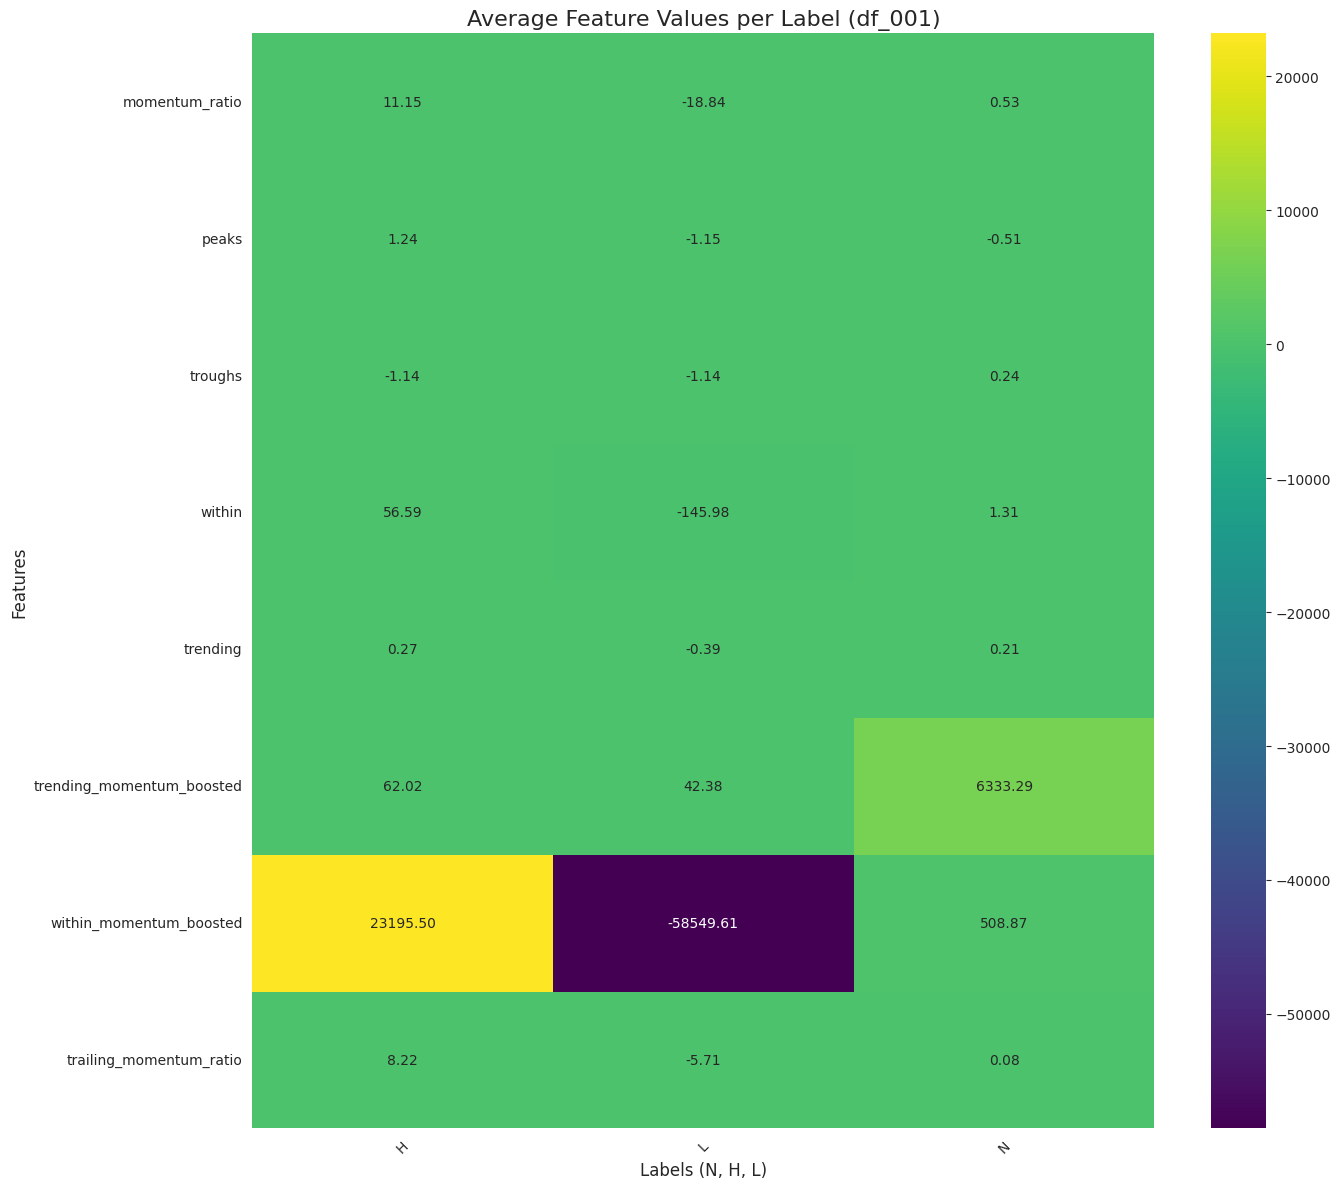

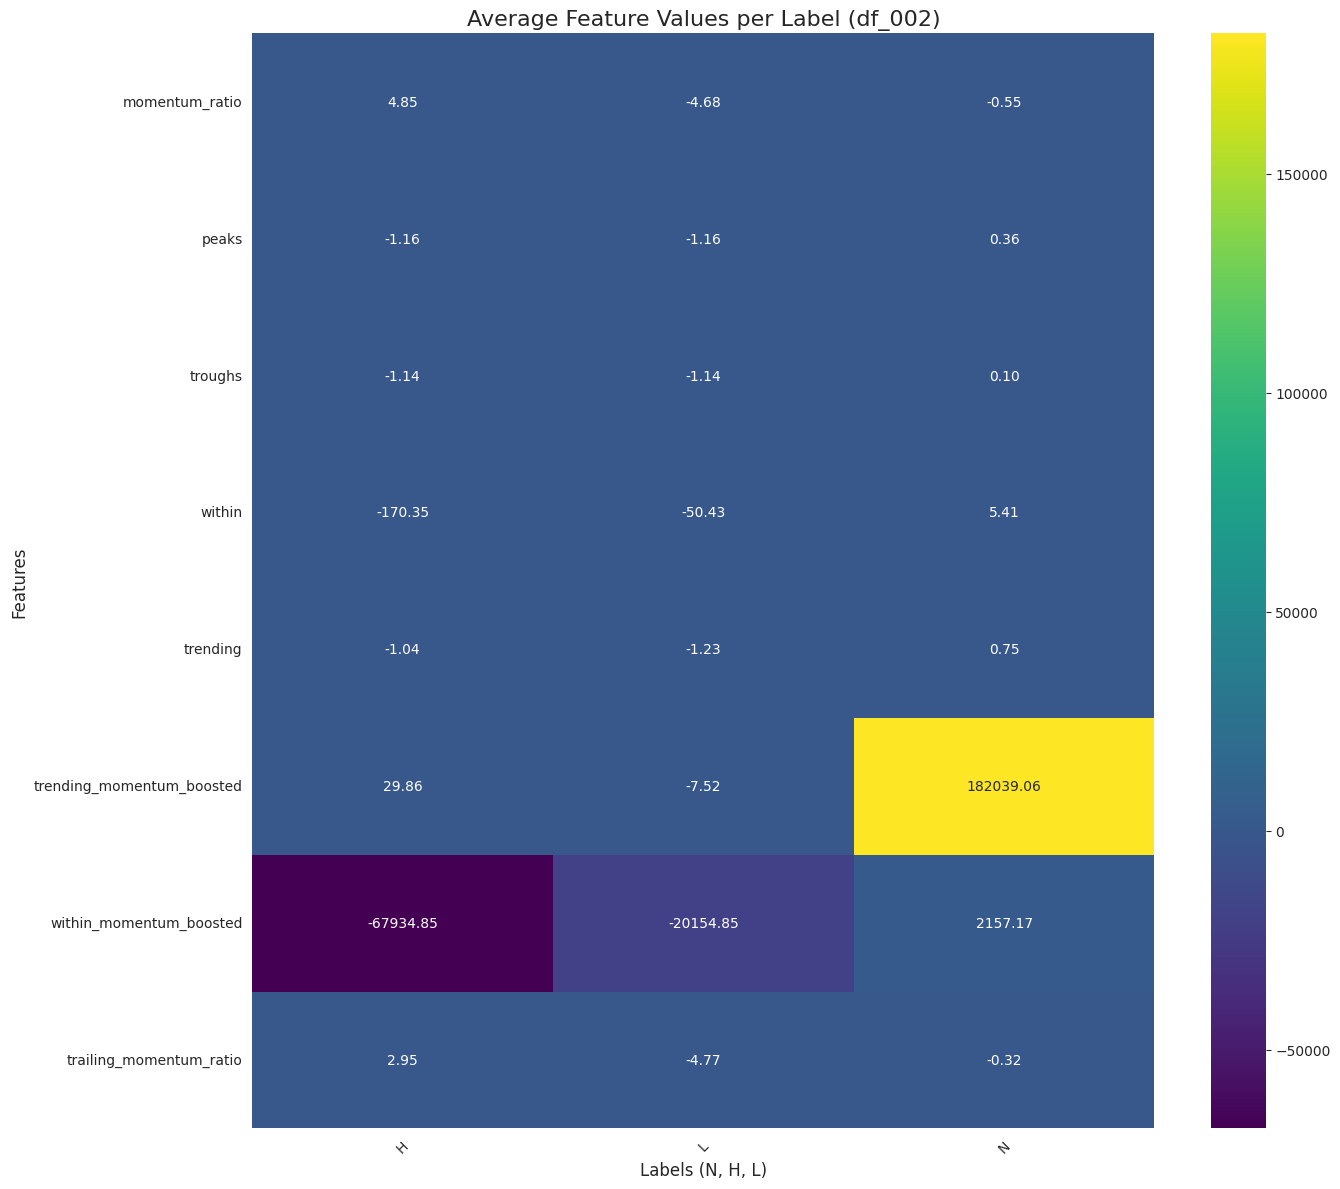

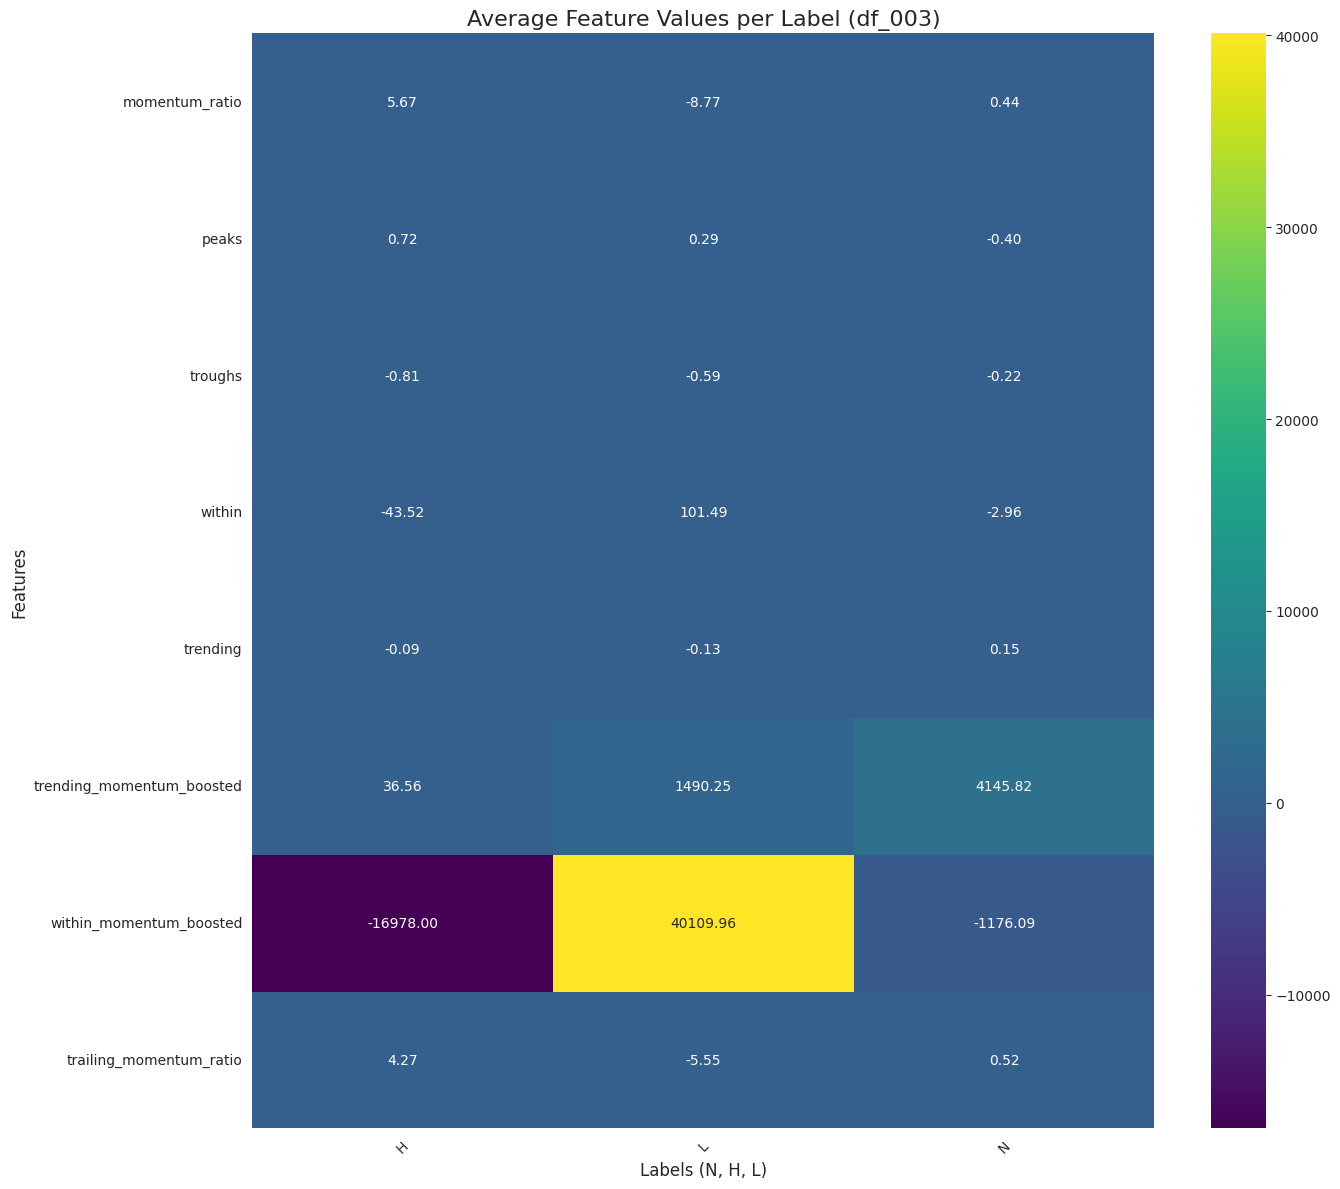

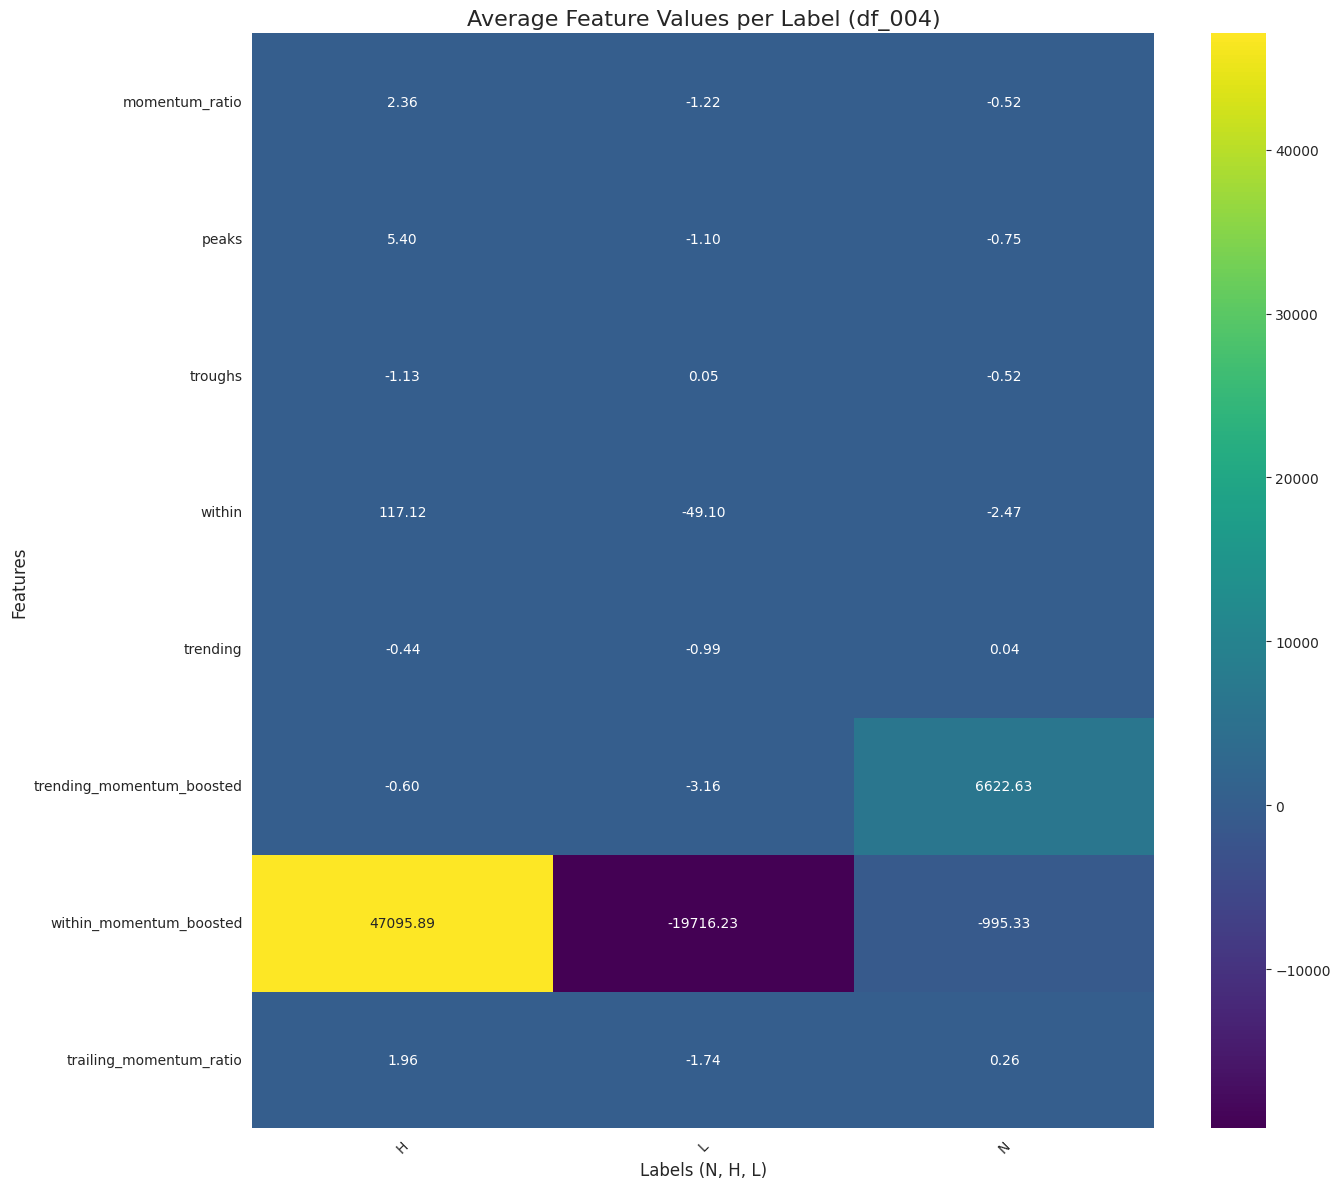

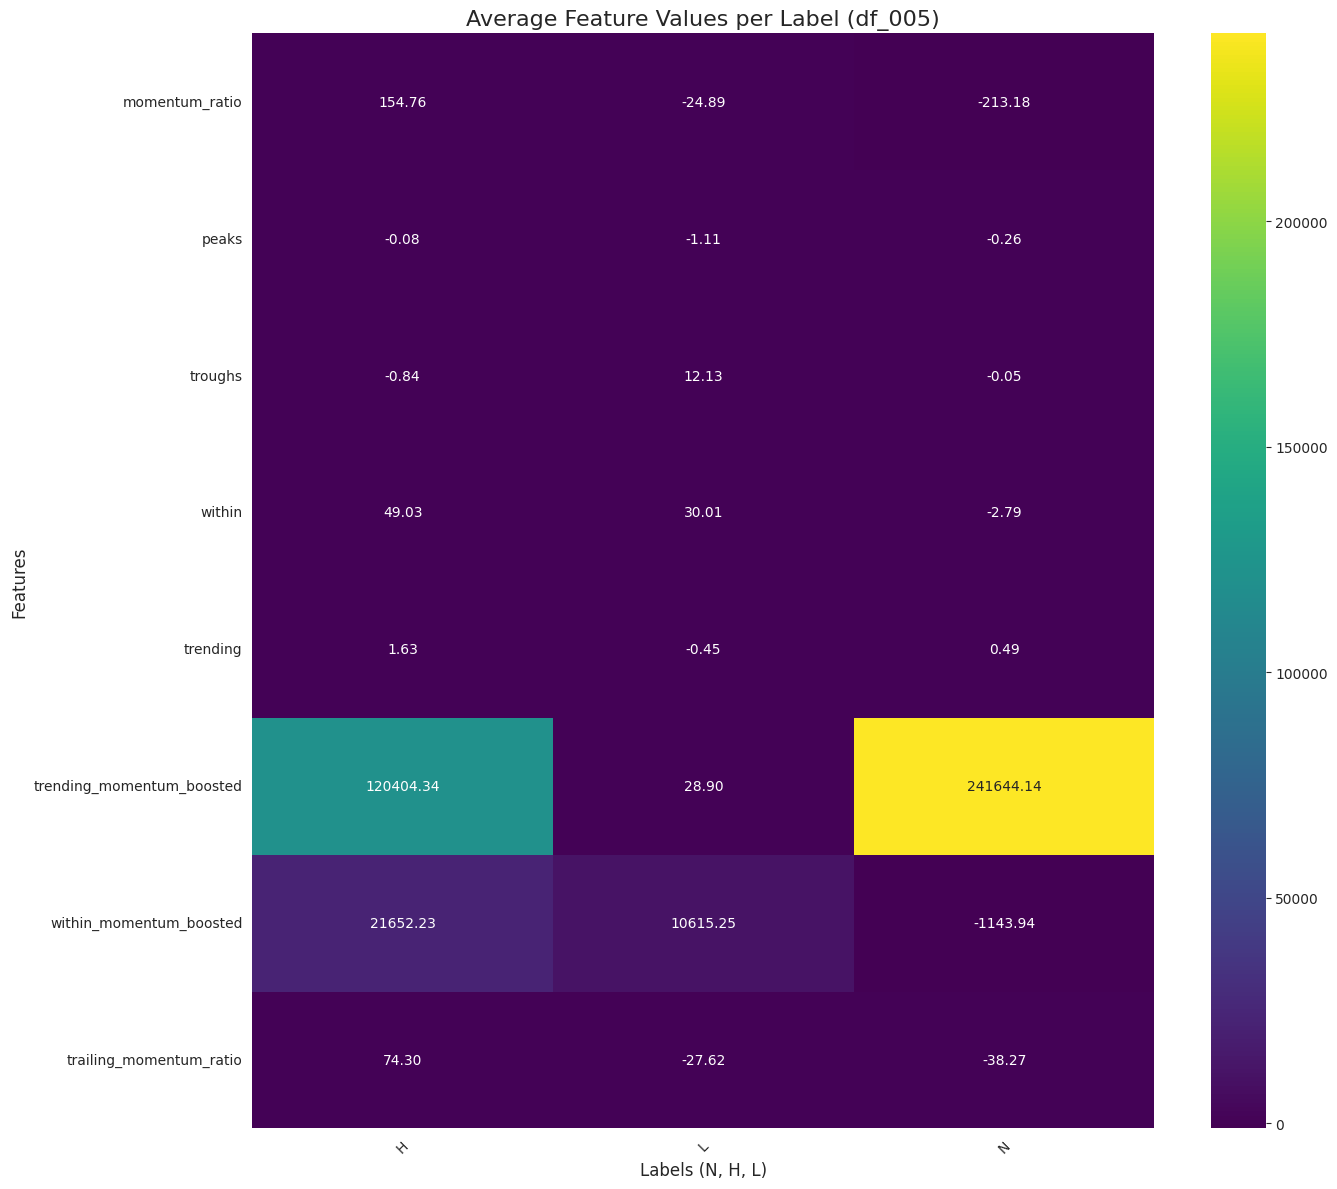

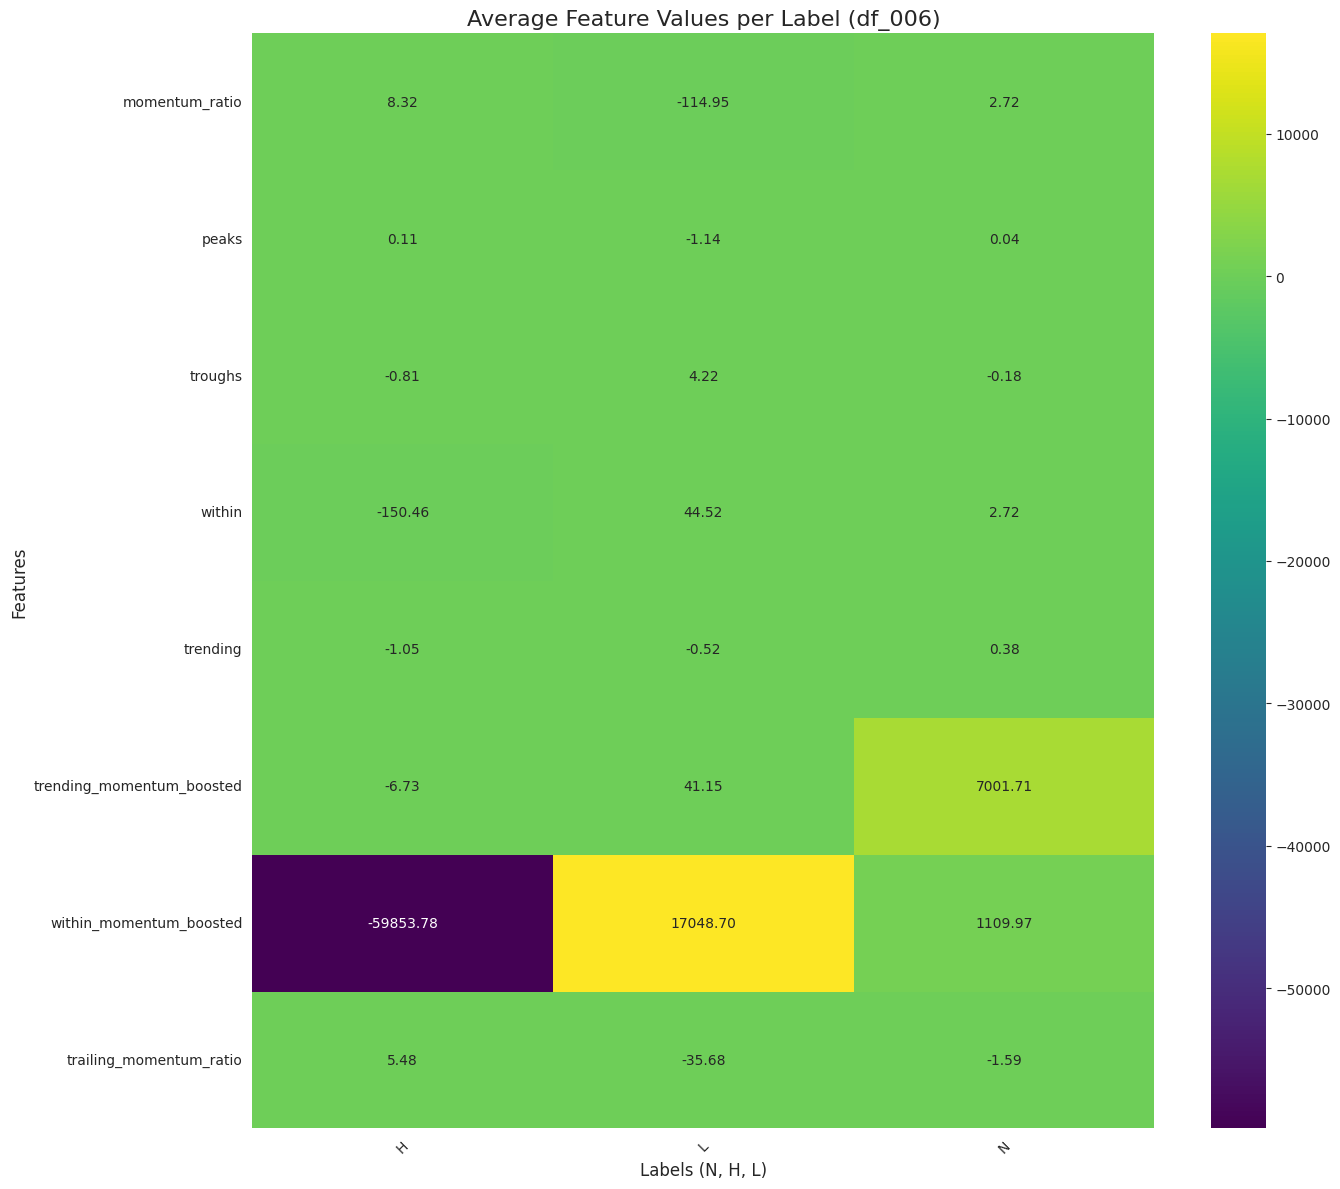

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define the new columns created in the previous script
heatmap_columns = [
    'momentum_ratio', 'peaks', 'troughs',
    'within', 'trending', 'trending_momentum_boosted', 'within_momentum_boosted', 'trailing_momentum_ratio'
]

# List of dataframes to process
dfs = {
    "df": df,
    "df_001": df_001,
    "df_002": df_002,
    "df_003": df_003,
    "df_004": df_004,
    "df_005": df_005,
    "df_006": df_006
}

# Directory to store heatmap plots
output_dir = "Data_analysis_plots/features-label_heatmap/"

# Create directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to plot heatmap of average feature values per label and save to file
def plot_label_heatmap(dataframe, name):
    if set(heatmap_columns).issubset(dataframe.columns):
        label_means = dataframe.groupby("class_label")[heatmap_columns].mean()
        if not label_means.empty:
            plt.figure(figsize=(14, 12))
            sns.heatmap(
                label_means.T, annot=True, cmap='viridis', fmt=".2f",
                annot_kws={"size": 10}
            )
            plt.title(f'Average Feature Values per Label ({name})', fontsize=16)
            plt.xlabel("Labels (N, H, L)", fontsize=12)
            plt.ylabel("Features", fontsize=12)
            plt.xticks(rotation=45, fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            # Save the plot to the specified directory
            output_path = os.path.join(output_dir, f"heatmap_{name}.png")
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            plt.close()

# Run for df and df_001 to df_006
for name, dataframe in dfs.items():
    plot_label_heatmap(dataframe, name)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming df_001 to df_006 are already processed and available
# Features to visualize
features = [
    'momentum_ratio', 'peaks', 'troughs',
    'within', 'trending', 'trending_momentum_boosted', 'within_momentum_boosted', 'trailing_momentum_ratio'
]

# Directory to store box plots
output_dir = "Data_analysis_plots/features-label_boxplot/"

# Create directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to create box plots for a given DataFrame
def plot_distributions(df, df_name):
    # Ensure all features exist in the DataFrame
    available_features = [f for f in features if f in df.columns]
    
    if not available_features:
        print(f"No valid features found in {df_name}")
        return

    # Set the style for better visualization
    sns.set_style("whitegrid")

    # Create a figure for each DataFrame with multiple subplots
    n_features = len(available_features)
    fig, axes = plt.subplots(n_features, 1, figsize=(10, 5 * n_features), sharex=False)
    fig.suptitle(f'Feature Distributions by Class Label for {df_name}', fontsize=16)

    for idx, feature in enumerate(available_features):
        ax = axes[idx] if n_features > 1 else axes
        sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
        ax.set_title(f'{feature}')
        ax.set_xlabel('Class Label')
        ax.set_ylabel('Value')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    # Save the plot to the specified directory
    plot_filename = os.path.join(output_dir, f"distribution_{df_name}.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved distribution plot for {df_name} as {plot_filename}")

# Visualize distributions for each DataFrame
plot_distributions(df_001, 'df_001')
plot_distributions(df_002, 'df_002')
plot_distributions(df_003, 'df_003')
plot_distributions(df_004, 'df_004')
plot_distributions(df_005, 'df_005')
plot_distributions(df_006, 'df_006')

/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

Saved distribution plot for df_001 as distribution_df_001.png


/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

Saved distribution plot for df_002 as distribution_df_002.png


/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

Saved distribution plot for df_003 as distribution_df_003.png


/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

Saved distribution plot for df_004 as distribution_df_004.png


/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

Saved distribution plot for df_005 as distribution_df_005.png


/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_216938/1637431450.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

Saved distribution plot for df_006 as distribution_df_006.png
